In [16]:
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#from scipy.special import jn
#from IPython.display import display, clear_output
import time

warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测的
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
pd.set_option('display.max_columns', None)

In [48]:
train = pd.read_csv('data/used_car_train_20200313.csv', sep=' ')
test = pd.read_csv('data/used_car_testA_20200313.csv', sep=' ')
train["is_train"] = 1
test["is_train"] = 0
all_data = pd.concat([train,test], ignore_index=True)
del all_data['seller'], all_data['offerType']
## 输出数据的大小信息
print('Train data shape:',train.shape)
print('TestA data shape:',test.shape)
train.head()

Train data shape: (150000, 32)
TestA data shape: (50000, 31)


,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,offerType,creatDate,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,is_train
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,0.0,1046,0,0,20160404,1850,43.357796,3.966344,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762,1
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,-,4366,0,0,20160309,3600,45.305273,5.236112,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522,1
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,0.0,2806,0,0,20160402,6222,45.978359,4.823792,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963,1
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,0.0,434,0,0,20160312,2400,45.687478,4.492574,-0.050616,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699,1
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,0.0,6977,0,0,20160313,5200,44.383511,2.031433,0.572169,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482,1


In [20]:
all_data.tail()

,SaleID,bodyType,brand,creatDate,fuelType,gearbox,is_train,kilometer,model,name,notRepairedDamage,power,price,regDate,regionCode,v_0,v_1,v_10,v_11,v_12,v_13,v_14,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9
199995,199995,4.0,4,20160320,0.0,0.0,0,15.0,4.0,20903,0.0,116,NaN,19960503,3219,45.621391,5.958453,-5.978511,1.303174,-1.207191,-1.981240,-0.357695,-0.918571,0.774826,-2.021739,0.284664,0.130044,0.049833,0.028807,0.004616
199996,199996,0.0,0,20160329,0.0,0.0,0,15.0,0.0,708,0.0,75,NaN,19991011,1857,43.935162,4.476841,-3.913825,1.759524,-2.075658,-1.154847,0.169073,-0.841710,1.328253,-1.292675,0.268101,0.108095,0.066039,0.025468,0.025971
199997,199997,0.0,1,20160305,1.0,1.0,0,15.0,49.0,6693,0.0,224,NaN,20040412,3452,46.537137,4.170806,-4.639065,0.654713,1.137756,-1.390531,0.254420,0.388595,-0.704689,-1.480710,0.269432,0.105724,0.117652,0.057479,0.015669
199998,199998,0.0,1,20160404,0.0,1.0,0,15.0,27.0,96900,0.0,334,NaN,20020008,1998,46.771359,-3.296814,1.833504,-2.828687,2.465630,-0.911682,-2.057353,0.243566,-1.277411,-0.404881,0.261152,0.000490,0.137366,0.086216,0.051383
199999,199999,1.0,6,20160322,NaN,1.0,0,9.0,166.0,193384,0.0,68,NaN,20041109,3276,43.731010,-3.121867,2.914571,-1.135270,0.547628,2.094057,-1.552150,0.027348,-0.808914,2.116551,0.228730,0.000300,0.103534,0.080625,0.124264


In [11]:
all_data.columns

Index(['SaleID', 'bodyType', 'brand', 'creatDate', 'fuelType', 'gearbox',
       'is_train', 'kilometer', 'model', 'name', 'notRepairedDamage',
       'offerType', 'power', 'price', 'regDate', 'regionCode', 'seller', 'v_0',
       'v_1', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'v_2', 'v_3', 'v_4',
       'v_5', 'v_6', 'v_7', 'v_8', 'v_9'],
      dtype='object')

In [5]:
train.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14'],
      dtype='object')

In [34]:
p = all_data["regionCode"].unique()
#q = p.tolist()
p.tolist()
p.sort()
p
# 从邮编中提取城市信息，相当于加入了先验知识
#data['city'] = data['regionCode'].apply(lambda x : str(x)[:-3])
#data = data
# 这个到底是不是邮编，还是脱敏了？先不做处理

Train_data.isnull().sum()

array([   0,    1,    2, ..., 8119, 8120, 8121], dtype=int64)

In [36]:
#train['offerType'].value_counts()
#offerType
#offerType 和 seller 倾斜度太大，删掉

p = train["price"].unique()
#q = p.tolist()
p.tolist()
p.sort()
p

array([   11,    12,    13, ..., 99900, 99990, 99999], dtype=int64)

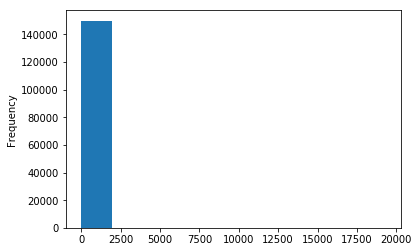

In [40]:
train['power'].plot.hist()

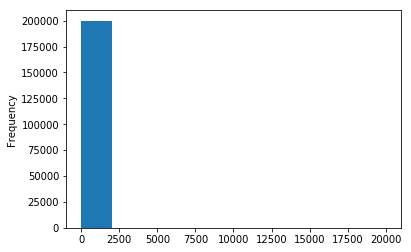

In [46]:
all_data['power'].plot.hist()

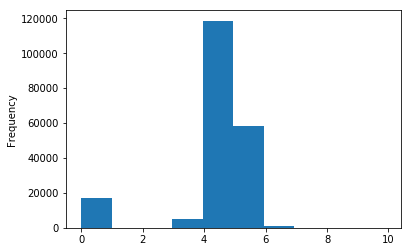

In [49]:
#train['power'].
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
all_data['power'] = np.log(all_data['power'] + 1) 
#all_data['power'] = ((all_data['power'] - np.min(all_data['power'])) / (np.max(all_data['power']) - np.min(all_data['power'])))
all_data['power'].plot.hist()

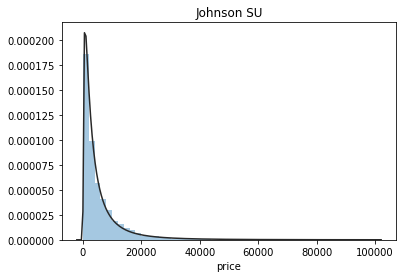

In [50]:
import scipy.stats as st
y = train['price']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)

In [52]:
# 提取特征
numerical_cols = train.select_dtypes(exclude = 'object').columns
print(numerical_cols)
categorical_cols = test.select_dtypes(include = 'object').columns
print(categorical_cols)

num_feas = ['price','power', 'kilometer', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13','v_14' ]

cate_feas = ['name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'regionCode',]

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'regionCode', 'seller', 'offerType',
       'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6',
       'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14',
       'is_train'],
      dtype='object')
Index(['notRepairedDamage'], dtype='object')


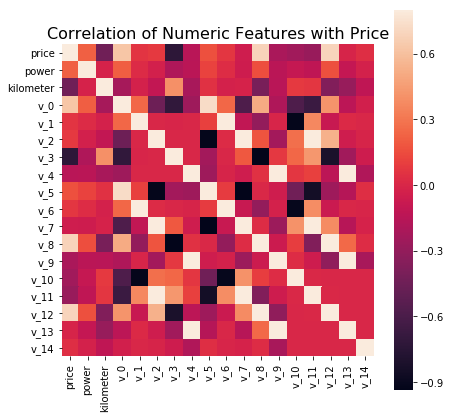

In [54]:
# 相关性分析
price_numeric = train[num_feas]
correlation = price_numeric.corr()
f , ax = plt.subplots(figsize = (7, 7))

plt.title('Correlation of Numeric Features with Price',y=1,size=16)

sns.heatmap(correlation,square = True,  vmax=0.8)

In [ ]:
price 和vo，v8，v12关联性较高
vo v5
v1 v6
v2 v7 v11
v4 v9 v13
关联性很高


In [11]:
## 选择特征列
feature_cols = [col for col in numerical_cols if col not in ['SaleID','name','regDate','creatDate','price','model','brand','regionCode','seller']]
feature_cols = [col for col in feature_cols if 'Type' not in col]

## 提前特征列，标签列构造训练样本和测试样本
X_data = Train_data[feature_cols]
Y_data = Train_data['price']

X_test  = TestA_data[feature_cols]

print('X train shape:',X_data.shape)
print('X test shape:',X_test.shape)

X train shape: (150000, 18)
X test shape: (50000, 18)


Sta of label:
_min 11
_max: 99999
_mean 5923.327333333334
_ptp 99988
_std 7501.973469876635
_var 56279605.942732885


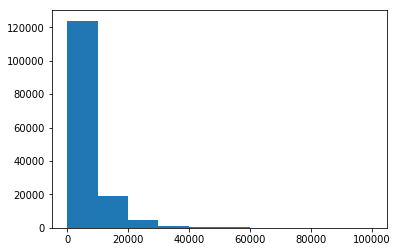

In [12]:
## 定义了一个统计函数，方便后续信息统计
def Sta_inf(data):
    print('_min',np.min(data))
    print('_max:',np.max(data))
    print('_mean',np.mean(data))
    print('_ptp',np.ptp(data))
    print('_std',np.std(data))
    print('_var',np.var(data))
print('Sta of label:')
Sta_inf(Y_data)
plt.hist(Y_data)
plt.show()
plt.close()
X_data = X_data.fillna(-1)
X_test = X_test.fillna(-1)

In [13]:
## xgb-Model
xgr = xgb.XGBRegressor(n_estimators=120, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #,objective ='reg:squarederror'

scores_train = []
scores = []

## 5折交叉验证方式
sk=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
for train_ind,val_ind in sk.split(X_data,Y_data):
    
    train_x=X_data.iloc[train_ind].values
    train_y=Y_data.iloc[train_ind]
    val_x=X_data.iloc[val_ind].values
    val_y=Y_data.iloc[val_ind]
    
    xgr.fit(train_x,train_y)
    pred_train_xgb=xgr.predict(train_x)
    pred_xgb=xgr.predict(val_x)
    
    score_train = mean_absolute_error(train_y,pred_train_xgb)
    scores_train.append(score_train)
    score = mean_absolute_error(val_y,pred_xgb)
    scores.append(score)

print('Train mae:',np.mean(score_train))
print('Val mae',np.mean(scores))

Train mae: 624.6318145374831
Val mae 714.187798259403


In [14]:
def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=150, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #, objective ='reg:squarederror'
    model.fit(x_train, y_train)
    return model

def build_model_lgb(x_train,y_train):
    estimator = lgb.LGBMRegressor(num_leaves=127,n_estimators = 150)
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
    }
    gbm = GridSearchCV(estimator, param_grid)
    gbm.fit(x_train, y_train)
    return gbm

In [15]:
## Split data with val
x_train,x_val,y_train,y_val = train_test_split(X_data,Y_data,test_size=0.3)

In [16]:
print('Train lgb...')
model_lgb = build_model_lgb(x_train,y_train)
val_lgb = model_lgb.predict(x_val)
MAE_lgb = mean_absolute_error(y_val,val_lgb)
print('MAE of val with lgb:',MAE_lgb)

print('Predict lgb...')
model_lgb_pre = build_model_lgb(X_data,Y_data)
subA_lgb = model_lgb_pre.predict(X_test)
print('Sta of Predict lgb:')
Sta_inf(subA_lgb)

Train lgb...
MAE of val with lgb: 688.2331858791043
Predict lgb...
Sta of Predict lgb:
_min -519.1502598641224
_max: 88575.10877210615
_mean 5922.982425989068
_ptp 89094.25903197027
_std 7377.297141258001
_var 54424513.11041347


In [17]:
print('Train xgb...')
model_xgb = build_model_xgb(x_train,y_train)
val_xgb = model_xgb.predict(x_val)
MAE_xgb = mean_absolute_error(y_val,val_xgb)
print('MAE of val with xgb:',MAE_xgb)

print('Predict xgb...')
model_xgb_pre = build_model_xgb(X_data,Y_data)
subA_xgb = model_xgb_pre.predict(X_test)
print('Sta of Predict xgb:')
Sta_inf(subA_xgb)

Train xgb...
MAE of val with xgb: 708.0878861309475
Predict xgb...
Sta of Predict xgb:
_min -163.78796
_max: 90366.05
_mean 5920.032
_ptp 90529.836
_std 7352.86
_var 54064548.0


In [18]:
## 这里我们采取了简单的加权融合的方式
val_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*val_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*val_xgb
val_Weighted[val_Weighted<0]=10 # 由于我们发现预测的最小值有负数，而真实情况下，price为负是不存在的，由此我们进行对应的后修正
print('MAE of val with Weighted ensemble:',mean_absolute_error(y_val,val_Weighted))

MAE of val with Weighted ensemble: 682.2392293175463


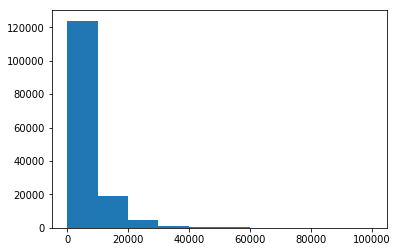

In [19]:
sub_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*subA_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*subA_xgb

## 查看预测值的统计进行
plt.hist(Y_data)
plt.show()
plt.close()

In [20]:
sub = pd.DataFrame()
sub['SaleID'] = TestA_data.SaleID
sub['price'] = sub_Weighted
sub.to_csv('./sub_Weighted.csv',index=False)

In [21]:
sub.head()

,SaleID,price
0,150000,39565.730996
1,150001,380.254421
2,150002,7688.313085
3,150003,11957.029682
4,150004,561.741828
